In [1]:
import os
from typing import Union, Tuple, List
import warnings
warnings.filterwarnings("ignore")

# 3rd party modules
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random


def data_preprocess(
    file_name: str, 
    macro_file_name: str,
    max_seq_len: int, 
    padding_value: float=-1.0,
    impute_method: str="mode", 
    scaling_method: str="minmax", 
) -> Tuple[np.ndarray, np.ndarray, List]:
    """Load the data and preprocess into 3d numpy array.
    Preprocessing includes:
    1. Remove outliers
    2. Extract sequence length for each patient id
    3. Impute missing data 
    4. Normalize data
    6. Sort dataset according to sequence length

    Args:
    - file_name (str): CSV file name
    - max_seq_len (int): maximum sequence length
    - impute_method (str): The imputation method ("median" or "mode") 
    - scaling_method (str): The scaler method ("standard" or "minmax")

    Returns:
    - processed_data: preprocessed data
    - time: ndarray of ints indicating the length for each data
    - params: the parameters to rescale the data 
    """

    #########################
    # Load data
    #########################

    # index = 'date'

    # # Load CSV
    # print("Loading data...\n")
    # ori_data = pd.read_csv(file_name)
    # print("ori_data:", ori_data.head(), ori_data.shape, ori_data.columns)

    # # Sort the data by date and ticker
    # ori_data = ori_data.sort_values(by=[index, 'ticker'])

    # # Group by 'ticker' and sort within each group
    # ori_data_group_by_ticker = ori_data.groupby("ticker")
    # ori_data = ori_data_group_by_ticker.apply(lambda x: x.sort_values(by=['date'], ascending=True)).reset_index(drop=True)

    # Load the data
    pv_projection={"Close":"underlying_close","Adj Close":"close","High":"high","Low":"low","Open":"open","Volume":"volume"}
    selected_macro_path = "/data3/hcxia/Adahist2/generator/GRT_GAN/data/macro_list.txt"
    with open(selected_macro_path, "r") as f:
        Macro_features = f.read().splitlines()
    print("Loading data...\n")
    ori_data = pd.read_csv(file_name)
    print("Original data shape:", ori_data.shape)
    print("Original data columns:", ori_data.columns)

    # load the macro data
    print("Loading macro data...\n")
    macro_data = pd.read_csv(macro_file_name)
    macro_data= macro_data[["Date"]+Macro_features]
    print("Macro data shape:", macro_data.shape)
    print("Macro data columns:", macro_data.columns)

    # rename the columns "Date" to "date" 
    ori_data.rename(columns={"Date": "date"}, inplace=True)
    macro_data.rename(columns={"Date": "date"}, inplace=True)

    # Sort the data by date and ticker
    ori_data = ori_data.sort_values(by=['date', 'ticker'])

    # Convert the 'date' column to datetime if it's not already
    ori_data['date'] = pd.to_datetime(ori_data['date'])

    # Determine the valid date range for each ticker
    date_ranges = ori_data.groupby('ticker')['date'].agg(['min', 'max'])
    print("Date ranges for each ticker:")
    print(date_ranges)

    # Find the maximum of the min dates and the minimum of the max dates
    common_start_date = date_ranges['min'].max()
    common_end_date = date_ranges['max'].min()

    # Restrict the dates
    restrict_start_date = pd.to_datetime("2000-01-03")
    restrict_end_date = pd.to_datetime("2020-12-31")
    # restrict_start_date = pd.Timestamp(restrict_start_date).tz_localize('UTC')
    # restrict_end_date = pd.Timestamp(restrict_end_date).tz_localize('UTC')
    # filter the data with the restricted date range
    print("Filtering data with the restricted date range...", restrict_start_date, restrict_end_date)
    # remove the timezone in ori_data
    ori_data['date'] = ori_data['date'].dt.tz_localize(None)
    ori_data = ori_data[(ori_data['date'] >= restrict_start_date) & (ori_data['date'] <= restrict_end_date)]
    # cast the date column to datetime
    macro_data['date'] = pd.to_datetime(macro_data['date'])
    macro_data = macro_data[(macro_data['date'] >= restrict_start_date) & (macro_data['date'] <= restrict_end_date)]

    # Drop the ticker that does not have full data in the restricted date range
    # ticker_to_drop = date_ranges[(date_ranges['min'] > restrict_start_date) | (date_ranges['max'] < restrict_end_date)].index
    # ori_data = ori_data[~ori_data['ticker'].isin(ticker_to_drop)]
    # update the bbin_list
    ticker_list = list(ori_data['ticker'].unique())
    # print("Dropped ticker number due to incomplete data in the restricted date range:", len(ticker_to_drop))

    print("Common date range across all ticker:")
    print(f"Start date: {common_start_date}")
    print(f"End date: {common_end_date}")

    # Filter the original data to only include rows within this restricted date range
    # filtered_data = ori_data[(ori_data['date'] >= restrict_start_date) & (ori_data['date'] <= restrict_end_date)]
    # print("Filtered data shape:", filtered_data.shape)
    filtered_data = ori_data

    # for each ticker
    # len_by_ticker = {}
    # for ticker in filtered_data['ticker'].unique():
    #     ticker_data = filtered_data[filtered_data['ticker'] == ticker]
    #     # get the length of the data
    #     data_len = len(ticker_data)
    #     len_by_ticker[ticker] = data_len
    # # find the max length of the data
    # max_len = max(len_by_ticker.values())
    # # throw away the ticker that has less data than the max length
    # ticker_to_drop = [ticker for ticker, data_len in len_by_ticker.items() if data_len < max_len]
    # filtered_data = filtered_data[~filtered_data['ticker'].isin(ticker_to_drop)]
    # print(len_by_ticker)
    # print("Dropped ticker number due to incomplete data in the restricted date range:", len(ticker_to_drop))




    # rename the columns in filtered_dat with pv_projection
    filtered_data.rename(columns=pv_projection, inplace=True)


    # 1. Build the full date index (the master list of dates)
    filtered_data['date'] = pd.to_datetime(filtered_data['date'])
    full_data_index = pd.to_datetime(sorted(filtered_data['date'].unique()))

    # 2. Expand each ticker's data to cover all dates in full_data_index
    full_data = pd.DataFrame()
    mask_matrix = pd.DataFrame()
    unique_tickers = filtered_data['ticker'].unique()

    for ticker in unique_tickers:
        # Extract rows for one ticker
        ticker_data = filtered_data[filtered_data['ticker'] == ticker].copy()
        
        print("=========================================")
        print(f"Expanding data for ticker: {ticker}")
        print("Date range in raw data  :", ticker_data['date'].min(), "->", ticker_data['date'].max())
        print("Number of unique dates  :", len(ticker_data['date'].unique()))
        
        # Reindex to the full list of dates (inserting NaN where data is missing)
        ticker_data = (
            ticker_data.set_index('date')
                    .reindex(full_data_index)   # fill in missing dates
                    .reset_index(drop=False)    # date back to a column
                    .rename(columns={'index': 'date'})
        )
        # Make sure the ticker column is present for missing rows
        ticker_data['ticker'] = ticker
        
        # identity and handle inf value
        print("Number of inf values per column before expanding:")
        print(ticker_data.isin([np.inf, -np.inf]).sum())
        ticker_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        print("Number of inf values per column after expanding:")
        print(ticker_data.isin([np.inf, -np.inf]).sum())

        print("Number of NaN values per column after expanding:")
        print(ticker_data.isnull().sum())
        # pick the columns that have NaN values
        # columns: open close high low volume
        ticker_mask_matrix = ticker_data[['open', 'close', 'high', 'low', 'volume']].isnull().values
        # check whther ticker mask matrix has the same length as the ticker data
        if len(ticker_mask_matrix) != len(ticker_data):
            print("The length of the mask matrix is not equal to the length of the ticker data")
            raise ValueError
        print("shape of the mask matrix: ", ticker_mask_matrix.shape)
        print("shape of the ticker data: ", ticker_data.shape)

        # # convert all 0 to np.nan in the ticker_data
        ticker_data.replace(0, np.nan, inplace=True)

        # # fill the missing data with the previous data
        ticker_data.fillna(method='bfill', inplace=True)
        ticker_data.fillna(method='ffill', inplace=True)

        print("Number of NaN values per column after filling:")
        print(ticker_data.isnull().sum())
        
        # Concatenate into our master DataFrame
        full_data = pd.concat([full_data, ticker_data], ignore_index=True)
        mask_matrix = pd.concat([mask_matrix, pd.DataFrame(ticker_mask_matrix)], ignore_index=True)

    print("=========================================")
    print("All tickers expanded to the full date range.\n")

    print("full data shape:", full_data.shape)
    print("mask matrix shape:", mask_matrix.shape)

    print("number of missing data sum in each feature:")
    print(mask_matrix.sum())
    
    
    # summary the number of True and False in the mask matrix
    print("number of True and False in the mask matrix:")
    print(mask_matrix.apply(pd.Series.value_counts).T)

    # Precompute filtered data for each ticker to avoid redundant filtering
    ticker_list = list(filtered_data['ticker'].unique())
    # ticker_data_dict = {ticker: filtered_data[filtered_data['ticker'] == ticker] for ticker in ticker_list}
    # use full_data instead of filtered_data
    ticker_data_dict = {ticker: full_data[full_data['ticker'] == ticker] for ticker in ticker_list}
    mask_by_ticker = {ticker: mask_matrix[full_data['ticker'] == ticker] for ticker in ticker_list}


    # 3. Identify which columns are features (excluding 'date' and 'ticker')
    # feature_cols = [col for col in full_data.columns if col not in ['date', 'ticker']]
    # feature_cols = [col for col in full_data.columns]

    # 4. Sort for consistent ordering
    full_data.sort_values(by=['date', 'ticker'], inplace=True)
    all_dates_sorted = full_data['date'].unique()
    all_tickers_sorted = full_data['ticker'].unique()
    time_steps=len(all_dates_sorted)

    # pivot the full_data to a 3D array (time_steps, number_of_tickers, number_of_features)
    # full_data = full_data.pivot_table(index='date', columns='ticker', values=feature_cols)

    print("full_data shape:", full_data.shape)

    # check inf and nan in the full_data
    print("Number of inf values per column in full_data:")
    print(full_data.isin([np.inf, -np.inf]).sum())
    print("Number of NaN values per column in full_data:")
    print(full_data.isnull().sum())
    # halt if there is inf or nan in the full_data
    if full_data.isin([np.inf, -np.inf]).sum().sum() > 0 or full_data.isnull().sum().sum() > 0:
        print("There is inf or nan in the full_data")
        raise ValueError


    macro_data = macro_data[macro_data['date'].isin(full_data_index)]
    # describe the macro data
    print("Macro data description:")
    print(macro_data.describe())
    # fill the missing data in the macro data
    macro_data.fillna(method='bfill', inplace=True)
    macro_data.fillna(method='ffill', inplace=True)

    # describe the macro data
    print("Macro data description after filling:")
    print(macro_data.describe())

    # check the number of NaN in macro data
    print("numb of NaN in macro data:")
    print(macro_data.isnull().sum())
    # Print the shape of the resulting array
    # print("Reshaped data shape:", reshaped_data.shape)
    


    print("Number of missing data in each feature after filling:")
    print(np.sum(filtered_data.isnull().sum()))

    # do the normalization for the macro data
    # do the minmax normalization for the macro data
    scaler = MinMaxScaler()
    macro_data[Macro_features] = scaler.fit_transform(macro_data[Macro_features])
    # Define feature sets
    PV_features = ['close', 'open', 'high', 'low', 'volume']

    # get number of Nan in the macro data after normalization
    print("numb of NaN in macro data after normalization:")
    print(macro_data.isnull().sum())





    print("Including the ticker number: ", len(ticker_list))

    # Initializing outputs and loop variables
    no = time_steps
    time = []
    output_data = []
    output_macro_data = []
    output_history_data = []
    output_mask_data = []
    output_transformation_params = {
        "original close": [],
        "original open": [],
        # "original volume": [],
        "original caj": []
    }
    output_starting_date = []
    output_orginal_open = []
    output_orginal_close = []
    output_adj_factor = []

    # Desired shape for the concatenated data
    expected_shape = (max_seq_len, 5)
    expected_shape_hist = (max_seq_len//2, 5)

    step=1
    error_counter = 0


    # calculate the pv_features for each ticker
    processed_pv_features_dict = {}
    pv_close_dict = {}
    pv_open_dict = {}
    pv_caj_dict = {}
    processed_pv_features_name = ['close_return', 'open_close_return', 'high_close_ratio_return', 'low_close_ratio_return', 'volume']
    for ticker in ticker_list:
        ticker_data = ticker_data_dict[ticker]
        # halt if there is inf or nan in the ticker_data
        if ticker_data.isin([np.inf, -np.inf]).sum().sum() > 0 or ticker_data.isnull().sum().sum() > 0:
            print("There is inf or nan in the ticker_data")
            raise ValueError
        mask_matrix_by_ticker = mask_by_ticker[ticker]

        pv_data_ticker = ticker_data[PV_features]

        pv_data_ticker_copy = pv_data_ticker.copy()
        processed_pv_features_, pv_close_, pv_open_, pv_caj_ = process_data_into_feature(pv_data_ticker_copy)
        # use the mask_matrix_by_ticker to replace the corresponding data in processed_pv_features_ with np.nan
        df_vals = processed_pv_features_.values
        mask_vals = mask_matrix_by_ticker.values  # same shape, same row order
        df_vals[mask_vals] = np.nan
        processed_pv_features_.iloc[:] = df_vals

        # processed_pv_features_[mask_matrix_by_ticker] = np.nan
        processed_pv_features_dict[ticker] = processed_pv_features_
        # print nan number in the processed_pv_features_ with  ticker
        print("DataFrame shape:", processed_pv_features_.shape)
        print("Mask shape:", mask_matrix_by_ticker.shape)
        print("DataFrame index:", processed_pv_features_.index)
        print("DataFrame columns:", processed_pv_features_.columns)

        # If mask_matrix_by_ticker is also a DataFrame:
        print("Mask index:", mask_matrix_by_ticker.index)
        print("Mask columns:", mask_matrix_by_ticker.columns)
        print("Mask dtype:", mask_matrix_by_ticker.dtypes)

        print("Number of NaN in the processed_pv_features_ with ticker by mask_matrix: ", ticker)
        print(mask_matrix_by_ticker.sum())
        print("Number of NaN in the processed_pv_features_ with ticker: ", ticker)
        print(processed_pv_features_.isnull().sum())
        pv_close_dict[ticker] = pv_close_
        pv_open_dict[ticker] = pv_open_
        pv_caj_dict[ticker] = pv_caj_

    # calculate the corrlation between tickers


    corr_dict = {}

    # Loop over the features you want to correlate across tickers
    for feat in processed_pv_features_name:
        # Build a DataFrame whose columns = tickers, rows = time
        feat_df = pd.DataFrame()

        for ticker, df_ticker in processed_pv_features_dict.items():
            # df_ticker should have columns like ['close_return', 'open_close_return', ...]
            
            # If all data shares the same index (e.g. same dates in the same order), 
            # you can directly assign:
            # print("df_ticker: ", df_ticker[feat])
            feat_df[ticker] = df_ticker[feat].reset_index(drop=True)
                    
        # Now compute the correlation matrix across tickers
        # print( "feat_df: ", feat_df)
        # raise ValueError
        corr_matrix = feat_df.corr()
        corr_dict[feat] = corr_matrix

        # Print or log
        print(f"Correlation matrix for feature = '{feat}':")
        print(corr_matrix)
        print("============================================")
    
    # save the heatmap of the correlation matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    for feat, corr_matrix in corr_dict.items():
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation matrix for feature = "{feat}"')
        plt.savefig(f'./corr_matrix_{feat}.png')

    # printhe index of each tickerdata in the processed_pv_features_dict
    # for ticker, df_ticker in processed_pv_features_dict.items():
    #     print("Ticker: ", ticker)
    #     print("Index: ", df_ticker.index)
    #     print("Columns: ", df_ticker.columns)
    # imputation with weight sum of the correlation
    tickers = sorted(processed_pv_features_dict.keys())
    ticker_idx_map = {tk: i for i, tk in enumerate(tickers)}  # map ticker -> int index

    beta = 1.0
    processed_pv_features_name = [
        'close_return', 'open_close_return', 'high_close_ratio_return',
        'low_close_ratio_return', 'volume'
    ]
    import math

    for feat in processed_pv_features_name:
        corr_matrix = corr_dict[feat]  # correlation matrix (DataFrame) for this feature

        # We'll use corr_matrix.iloc[row_i, row_j] with the integer positions
        # but we need the same ticker ordering in corr_matrix. 
        # Make sure corr_matrix is also aligned to the 'tickers' list order if necessary.
        
        for ticker in tickers:
            df_ticker = processed_pv_features_dict[ticker]
            
            # Get numeric column index for the feature
            feat_col_idx = df_ticker.columns.get_loc(feat)

            # Iterate by integer row index
            num_rows = len(df_ticker)
            for i in range(num_rows):
                val = df_ticker.iloc[i, feat_col_idx]
                if pd.isna(val):
                    # Gather valid tickers that have a non-NaN value in row i
                    valid_tickers = []
                    for other_ticker in tickers:
                        if other_ticker == ticker:
                            continue
                        df_other = processed_pv_features_dict[other_ticker]
                        other_val = df_other.iloc[i, feat_col_idx]
                        if not pd.isna(other_val):
                            valid_tickers.append(other_ticker)

                    # If no other ticker has data for this row i, skip
                    if len(valid_tickers) == 0:
                        continue

                    # Gather correlations + values from valid tickers
                    corrs = []
                    values = []
                    for vt in valid_tickers:
                        # correlation from ticker to vt via integer position
                        c = corr_matrix.iloc[ticker_idx_map[ticker], ticker_idx_map[vt]]
                        if pd.isna(c):
                            continue

                        other_val = processed_pv_features_dict[vt].iloc[i, feat_col_idx]
                        corrs.append(c)
                        values.append(other_val)

                    if len(corrs) == 0:
                        continue

                    # normalize to weights to 1 
                    exps = [math.exp(beta * c) for c in corrs]
                    sum_exps = sum(exps)
                    weights = [x / sum_exps for x in exps]

                    # Weighted sum
                    imputed_val = sum(w * v for w, v in zip(weights, values))

                    # Assign
                    df_ticker.iloc[i, feat_col_idx] = imputed_val

            # Optional check: if still NaNs remain, you can decide to raise an error or do another pass
            if df_ticker[feat].isna().any():
                print(f"[WARNING] {df_ticker[feat].isna().sum()} NaNs remain in {ticker} / {feat} after imputation.")
                raise ValueError
            

            # do a clip for outlier in the df_ticker
            for column in df_ticker.columns:
                # get the 3% and 97% quantile
                q03 = df_ticker[column].quantile(0.03)
                q97 = df_ticker[column].quantile(0.97)
                # clip the outlier
                df_ticker[column] = df_ticker[column].clip(q03, q97)
            
            processed_pv_features_dict[ticker] = df_ticker


    # Loop through the data to collect and process samples
    # reset the index of the macro_data
    macro_data.reset_index(drop=True, inplace=True)
    for i in tqdm(range(0, no - max_seq_len, step)):
        # Initialize lists to store data for all ticker in the current window
        curr_pv_sample_list = []
        curr_macro_sample = []
        curr_mask_sample_list = []
        history_pv_sample_list = []
        ticker_include = []
        starting_date_list = []
        original_open_list = []
        original_close_list = []
        adj_factor_list = []
        error_data_flag = False

        for ticker in ticker_list:
            ticker_data = ticker_data_dict[ticker]
            # halt if there is inf or nan in the ticker_data
            if ticker_data.isin([np.inf, -np.inf]).sum().sum() > 0 or ticker_data.isnull().sum().sum() > 0:
                print("There is inf or nan in the ticker_data")
                raise ValueError
            mask_matrix_by_ticker = mask_by_ticker[ticker]

            # Process the PV data into features
            macro_data_ticker = macro_data[Macro_features]


            # Ensure that the current window is within bounds for this ticker
            if i + max_seq_len > len(ticker_data):
                print("The current window is out of bounds for this ticker,throwing it away")
                continue


            pv_data_ticker = ticker_data[PV_features]

            # pv_data_ticker_copy = pv_data_ticker.copy()
            # processed_pv_features, pv_close, pv_open, pv_caj = process_data_into_feature(pv_data_ticker_copy)

            # Rename the columns with the processed features
            
            processed_pv_features = processed_pv_features_dict[ticker]
            pv_close = pv_data_ticker['close'].values[i:i + max_seq_len]
            pv_underlying_close = ticker_data['underlying_close'].values[i:i + max_seq_len]
            # calculate the caj_factor by pv_underlying_close/pv_close
            caj_factor = np.zeros_like(pv_close)
            np.divide(pv_underlying_close, pv_close, out=caj_factor, where=pv_close != 0)
            
            pv_open = pv_data_ticker['open'].values[i]
            pv_caj = pv_caj_dict[ticker]

            new_ticker_data = pd.concat([processed_pv_features, macro_data_ticker], axis=1)
            new_ticker_data.columns = processed_pv_features_name + Macro_features

            # make sure there is no nan in the new_ticker_data
            if processed_pv_features.isnull().sum().sum() > 0:
                print("There is nan in the processed_pv_features")
                raise ValueError

            # Get the current and historical pv data slices (window) of length max_seq_len
            curr_pv_sample = new_ticker_data.iloc[i:i + max_seq_len][processed_pv_features_name].values
            history_pv_sample = new_ticker_data.iloc[max(0,i-max_seq_len):max(0,i-max_seq_len)+max_seq_len][processed_pv_features_name].values
            # history_pv_sample = new_ticker_data.iloc[i:i+max_seq_len//2][processed_pv_features_name].values
            curr_mask_sample = mask_matrix_by_ticker.iloc[i:i + max_seq_len].values
            # # cast the corresponding data in curr_pv_sample to 0 if the corresponding data in curr_mask_sample is True
            # curr_pv_sample[curr_mask_sample] = 0
            # # cast the corresponding data in history_pv_sample to 0 if the corresponding data in history_mask_sample is True
            # history_pv_sample[history_mask_sample] = 0
            starting_date=ticker_data.iloc[i]['date']

            # if curr_pv_sample and curr_mask_sample has different shape, raise error
            # if curr_pv_sample.shape[0] != curr_mask_sample.shape[0] or curr_pv_sample.shape[1] != curr_mask_sample.shape[1]:
            #     print("The shape of the current sample and mask sample is not correct,throwing it away")
            #     raise ValueError 

            # Normalize the current pv data with the history data rolling window
            history_mean = history_pv_sample.mean(axis=0)
            history_std = history_pv_sample.std(axis=0)
            # print("history_mean: ", history_mean)
            # change the 0 in the history_std to 1 to avoid division by zero
            history_std[history_std == 0] = 1
            # if history_mean contains inf or nan, throw it away
            if np.isnan(history_mean).any() or np.isinf(history_mean).any():
                print("The history mean contains nan or inf")
                print("ticker: ", ticker)
                print("starting date: ", starting_date)
                print("history_mean: ", history_mean)
                print("history_pv_sample: ", history_pv_sample[:10])
                error_data_flag = True
                break
            curr_pv_sample_normalized = (curr_pv_sample - history_mean) / history_std
            # history_pv_sample_normalized = (history_pv_sample - history_mean) / history_std



            # if curr_macro_sample is None:
            macro_data_sample = macro_data_ticker.iloc[i:i + max_seq_len].values
            # not not normalize the macro data as we have already normalized the macro data before with the whole period
            # macro_data_sample = (macro_data_sample - macro_data_sample.mean(axis=0)) / macro_data_sample.std(axis=0)
            curr_macro_sample = macro_data_sample


            # print("macro_data_sample", macro_data_sample)
            




            # Pad the current and history samples if their shape is smaller than expected
            if curr_pv_sample_normalized.shape != expected_shape:
                print("The shape of the current sample is not correct,throwing it away")
                raise ValueError
                # pad_width = ((0, max_seq_len - curr_pv_sample_normalized.shape[0]), (0, 0))
                # curr_pv_sample_normalized = np.pad(curr_pv_sample_normalized, pad_width, mode='constant', constant_values=np.nan)
            # if history_pv_sample_normalized.shape != expected_shape:
            #     print("The shape of the history sample is not correct,throwing it away")
            #     raise ValueError
                # pad_width = ((0, max_seq_len - history_pv_sample_normalized.shape[0]), (0, 0))
                # history_pv_sample_normalized = np.pad(history_pv_sample_normalized, pad_width, mode='constant', constant_values=np.nan)
            # if macro_data_sample.shape != expected_shape:
            #     print("The shape of the macro sample is not correct,throwing it away")
            #     continue
                # pad_width = ((0, max_seq_len - history_pv_sample_normalized.shape[0]), (0, 0))
                # history_pv_sample_normalized = np.pad(history_pv_sample_normalized, pad_width, mode='constant', constant_values=np.nan)
            # Append the data for the current ticker to the lists

            #stop if curr_pv_sample_normalized contains nan
            if np.isnan(curr_pv_sample).any():
                print("The current sample contains nan,throwing it away")
                raise ValueError
            if np.isnan(curr_pv_sample_normalized).any():
                print("The current normalized sample contains nan,throwing it away")
                raise ValueError
            # if np.isnan(history_pv_sample_normalized).any():
            #     print("The history sample contains nan,throwing it away")
            #     raise ValueError
            if np.isnan(curr_mask_sample).any():
                print("The mask sample contains nan,throwing it away")
                raise ValueError

            curr_pv_sample_list.append(curr_pv_sample_normalized)
            history_pv_sample_list.append(history_pv_sample)
            curr_mask_sample_list.append(curr_mask_sample)
            ticker_include.append(ticker)
            starting_date_list.append(starting_date)
            original_open_list.append(pv_open)
            original_close_list.append(pv_close)
            adj_factor_list.append(caj_factor)

            # Append the original close, open, volume, and caj
            output_transformation_params["original close"].append(pv_close)
            output_transformation_params["original open"].append(pv_open)
            # output_transformation_params["original volume"].append(pv_volume)
            output_transformation_params["original caj"].append(pv_caj)

        if error_data_flag:
            error_counter += 1
            continue
        # Concatenate data from all ticker along the feature axis
        curr_pv_sample_concat = np.concatenate(curr_pv_sample_list, axis=1)
        history_pv_sample_concat = np.concatenate(history_pv_sample_list, axis=1)
        curr_mask_sample_concat = np.concatenate(curr_mask_sample_list, axis=1)
        starting_date_concat = np.array(starting_date_list)
        original_open_concat = np.array(original_open_list)
        original_close_concat = np.array(original_close_list)
        adj_factor_concat = np.array(adj_factor_list)



        # Ensure the shape is correct
        if curr_pv_sample_concat.shape[-1] != 5 * len(ticker_list):
            print(curr_pv_sample_concat.shape, curr_macro_sample.shape, history_pv_sample_concat.shape)
            print("The shape of the concatenated data is not correct, should be 5 * len(ticker_list):" ,5 *len(ticker_list))
            # print("ticker_include: ", ticker_include, len(ticker_include))
            continue
        
        if i%1000==0:
            print("curr_pv_sample_concat", curr_pv_sample_concat)
            print("curr_macro_sample", curr_macro_sample)
            print("history_pv_sample_concat", history_pv_sample_concat)
            print("curr_mask_sample_concat", curr_mask_sample_concat)

        # Append the concatenated data to the output lists
        output_data.append(curr_pv_sample_concat)
        output_macro_data.append(curr_macro_sample)
        output_history_data.append(history_pv_sample_concat)
        output_mask_data.append(curr_mask_sample_concat)
        output_starting_date.append(starting_date_concat)
        output_orginal_open.append(original_open_concat)
        output_orginal_close.append(original_close_concat)
        output_adj_factor.append(adj_factor_concat)


        # Append the time step length
        time.append(max_seq_len)

    # Convert lists to numpy arrays
    output_data = np.array(output_data)
    output_macro_data = np.array(output_macro_data)
    output_history_data = np.array(output_history_data)
    output_mask_data = np.array(output_mask_data)
    output_starting_date = np.array(output_starting_date)
    output_orginal_open = np.array(output_orginal_open)
    output_orginal_close = np.array(output_orginal_close)
    output_adj_factor = np.array(output_adj_factor)

    # Check the shapes of the output data
    print("error counter: ", error_counter)
    print("Output data shape:", output_data.shape)
    print("Output macro data shape:", output_macro_data.shape)
    print("Output history data shape:", output_history_data.shape)
    print("Output mask data shape:", output_mask_data.shape)
    print("Output starting date shape:", output_starting_date.shape)
    print("Output adj factor shape:", output_adj_factor.shape)


    # Return the processed data
    return output_data, output_macro_data, output_history_data,output_mask_data,output_starting_date, time, max_seq_len,ticker_list,output_orginal_open,output_orginal_close, output_adj_factor



def imputer(
    curr_data: np.ndarray, 
    impute_vals: List, 
    zero_fill: bool = True
) -> np.ndarray:
    """Impute missing data given values for each columns.

    Args:
        curr_data (np.ndarray): Data before imputation.
        impute_vals (list): Values to be filled for each column.
        zero_fill (bool, optional): Whather to Fill with zeros the cases where 
            impute_val is nan. Defaults to True.

    Returns:
        np.ndarray: Imputed data.
    """

    curr_data = pd.DataFrame(data=curr_data)
    impute_vals = pd.Series(impute_vals)
    
    # Impute data
    imputed_data = curr_data.fillna(impute_vals)

    # Zero-fill, in case the `impute_vals` for a particular feature is `nan`.
    imputed_data = imputed_data.fillna(0.0)

    # Check for any N/A values
    if imputed_data.isnull().any().any():
        raise ValueError("NaN values remain after imputation")

    return imputed_data.to_numpy()


def process_data_into_feature(df):
    """
    Process the input DataFrame to generate the required features.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ["open", "close", "high", "low", "volume", "caj"]
    
    Returns:
    pd.DataFrame: DataFrame with processed features
    pd.Series: Original close series
    pd.Series: caj column
    """
    # # for each column in the df, check if there is 0 in the column if so, replace it with the previous value
    # for column in df.columns:
    #     df[column] = df[column].replace(0, method='ffill')
    # calculate the dollar volume by close * volume
    dollar_volume = df['close'] * df['volume']
    # calcualte the log of the dollar volume
    log_dollar_volume = np.log(dollar_volume)
    # hanlde the inf in the log_dollar_volume
    # turn the -inf to np.nan
    log_dollar_volume[log_dollar_volume == -np.inf] = np.nan
    # fill the nan with the previous value
    log_dollar_volume = log_dollar_volume.fillna(method='ffill')
    # raise error if there is inf or nan in the log_dollar_volume
    if np.isinf(log_dollar_volume).any() or np.isnan(log_dollar_volume).any():
        print("There is inf or nan in the log_dollar_volume")
        print(df['close'], df['volume'])
        print(log_dollar_volume)
        # print the place where the inf or nan is
        print(np.where(np.isinf(log_dollar_volume)))
        raise ValueError

    # Smooth the OHLC data by dividing by caj
    smoothed_open = df['open'] 
    smoothed_close = df['close'] 
    smoothed_high = df['high'] 
    smoothed_low = df['low'] 
    
    # Calculate close(t+1) - close(t) return
    close_return = (smoothed_close.shift(-1) - smoothed_close) / smoothed_close
    
    # Calculate open(t+1) - close(t) return
    open_close_return = (smoothed_open.shift(-1) - smoothed_close) / smoothed_close

    # foward fill the nan in the close_return and open_close_return to avoid calculation error
    close_return = close_return.ffill()
    open_close_return = open_close_return.ffill()
    
    # Calculate high/close ratio
    high_close_ratio_return = smoothed_high / smoothed_close -1
    
    # Calculate low/close ratio
    low_close_ratio_return = smoothed_low / smoothed_close -1

    # # calcluate the volume return 
    # volume_return = (df['volume'].shift(-1) - df['volume']) / df['volume']
    # volume_return = volume_return.ffill()
    
    # Combine all features into a new DataFrame
    df_features = pd.DataFrame({
        'close_return': close_return,
        'open_close_return': open_close_return,
        'high_close_ratio_return': high_close_ratio_return,
        'low_close_ratio_return': low_close_ratio_return,
        'volume': log_dollar_volume
    })
    
    return df_features, smoothed_close, df["open"].iloc[0],  None

def revert_feature_into_data(df_features, original_close, original_open , caj_column):
    """
    Revert the processed features back to the original OHLC data.
    
    Parameters:
    df_features (pd.DataFrame): DataFrame with processed features
    original_close (pd.Series): Series with the original close values
    caj_column (pd.Series): Series with the caj values
    
    Returns:
    pd.DataFrame: DataFrame with original columns ["open", "close", "high", "low", "volume"]
    """
    # Reconstruct smoothed close values from the features
    # reconstructed the close from the fiorst close value and by accumulating the close_return
    # smoothed_close = ((original_close * (1 + df_features.iloc[:,0]).cumprod()).shift(1).fillna(original_close))/caj_column
    # reconstruct ht close from the orginal close price and the close return
    # print('orginal_close: ', original_close)
    # print('orginal_volume: ', original_volume)
    # smoothed_close = (original_close.shift(1) * (1 + df_features.iloc[:,0]).shift(1)).fillna(original_close.iloc[0])
    # Initialize smoothed_close with the Day 1 close price
    smoothed_close = [original_close.iloc[0]]

    # Calculate the subsequent synthetic prices recursively
    for t in range(len(df_features)-1):
        next_price = smoothed_close[-1] * (1 + df_features.iloc[t, 0])  # Recursive compounding
        smoothed_close.append(next_price)
    # cast the smoothed_close to a numpy array
    smoothed_close = np.array(smoothed_close)

    # Convert the list to a Pandas Series (optional, for easier manipulation)
    smoothed_close = pd.Series(smoothed_close, index=original_close.index)

    # print(smoothed_close.shift(1),(df_features.iloc[:,1]+1).shift(1))
    smoothed_open = (smoothed_close.shift(1) * (df_features.iloc[:,1]+1).shift(1)).fillna(original_open)
    smoothed_high = smoothed_close * (1 + df_features.iloc[:,2])
    smoothed_low = smoothed_close * (1 + df_features.iloc[:,3])

    print("feature shape: ", df_features.shape)
    print("original_close" , original_close)
    print("original_open" , original_open)
    print("smoothed_close shape: ", smoothed_close.shape)
    print("smoothed_open shape: ", smoothed_open.shape)
    print("smoothed_high shape: ", smoothed_high.shape)
    print("smoothed_low shape: ", smoothed_low.shape)

    # log calcualtion of the smoothed close step by step
    # print("1+close_return: ", (1 + df_features.iloc[:,0]))
    # print("cumprod: ", ((original_close * (1 + df_features.iloc[:,0]).cumprod()).shift(1).fillna(original_close))/caj_column)
    # # calcualte the nan in the smoothed_close
    # print("nan in smoothed_close: ", smoothed_close.isna().sum())
    # print(smoothed_close, smoothed_open, smoothed_high, smoothed_low) 
    
    # Unsmooth the OHLC data by multiplying by caj
    close = smoothed_close
    open_ = smoothed_open 
    high = smoothed_high 
    low = smoothed_low 
    # revert the volume with volume return
    # volume = (original_volume * (1 + df_features.iloc[:,4]).cumprod()).shift(1).fillna(original_volume)
            
    volumn = np.exp(df_features.iloc[:,4])/close
    
    # Combine reconstructed values into a new DataFrame
    df_original = pd.DataFrame({
        'open': open_,
        'close': close,
        'high': high,
        'low': low,
        'volume': volumn
    })
    
    return df_original


In [2]:
# Creating a sample DataFrame for testing
data = pd.DataFrame({
    'open': [100, 102, 104, 103, 105],
    'close': [101, 103, 102, 106, 108],
    'high': [102, 104, 105, 107, 109],
    'low': [99, 100, 101, 102, 103],
    'volume': [1000, 1500, 1200, 1300, 1400]
    # 'caj': [2, 2, 2, 2, 2]
})

print("Original Data:")
print(data.head())
# Process the data
processed_data, original_close,original_open, caj = process_data_into_feature(data.copy())
# print(original_close,original_open)
print("Processed Data:")
print(processed_data)

# Revert the processed data
original_data_reconstructed = revert_feature_into_data(
    processed_data,
    original_close,
    original_open,
    caj
)

# Print the reconstructed data
print("Reconstructed Data:")
print(original_data_reconstructed)

# Check if the reconstructed data is the same as the original data by equality
print(original_data_reconstructed.equals(data))


Original Data:
   open  close  high  low  volume
0   100    101   102   99    1000
1   102    103   104  100    1500
2   104    102   105  101    1200
3   103    106   107  102    1300
4   105    108   109  103    1400
Processed Data:
   close_return  open_close_return  high_close_ratio_return  \
0      0.019802           0.009901                 0.009901   
1     -0.009709           0.009709                 0.009709   
2      0.039216           0.009804                 0.029412   
3      0.018868          -0.009434                 0.009434   
4      0.018868          -0.009434                 0.009259   

   low_close_ratio_return     volume  
0               -0.019802  11.522876  
1               -0.029126  11.947949  
2               -0.009804  11.715050  
3               -0.037736  11.833559  
4               -0.046296  11.926359  
feature shape:  (5, 5)
original_close 0    101
1    103
2    102
3    106
4    108
Name: close, dtype: int64
original_open 100
smoothed_close shape:  (5

Loading data...

Original data shape: (81697, 8)
Original data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'ticker'],
      dtype='object')
Loading macro data...

Macro data shape: (9041, 47)
Macro data columns: Index(['Date', 'exp.real.short.rate.5', 'exp.inflation.5', 'real.term.prem.5',
       'inflation.risk.prem.5', 'tips.liq.prem.5', 'nominal.yield.raw.5',
       'nominal.yield.fitted.5', 'ic.raw.5', 'ic.fitted.5',
       'exp.real.short.rate.10', 'exp.inflation.10', 'tips.liq.prem.10',
       'nominal.yield.raw.10', 'nominal.yield.fitted.10', 'ic.raw.10',
       'ic.fitted.10', 'exp.real.short.rate.5f5', 'exp.inflation.5f5',
       'tips.liq.prem.5f5', 'nominal.yield.raw.5f5',
       'nominal.yield.fitted.5f5', 'lmci', 'CPIAUCSL', 'FEDFUNDS', 'GS10',
       'M1NS', 'M2SL', 'T10YIEM', 'UNRATE', 'gz_spread', 'ebp', 'est_prob',
       'REALIZED_1M', 'REALIZED_3M', 'REALIZED_6M', 'FCI-G Index (baseline)',
       '10Yr Treasury', 'Mortgage Ra

  0%|          | 2/5164 [00:00<13:24,  6.42it/s]

curr_pv_sample_concat [[-1.32157257 -2.25466874 -0.27432817 ...  0.35467412  0.31149432
   0.58146274]
 [-0.94031119 -0.64025609  1.32979306 ...  0.35467412  0.31149432
   0.43251281]
 [-1.32157257  0.82849907  1.32979306 ...  0.35467412  0.31149432
   0.7720367 ]
 ...
 [ 0.54112476 -0.6264061   0.13757175 ... -1.65135791  0.31149432
  -2.23590163]
 [-1.32157257 -0.17063177 -0.73344712 ... -2.97780451 -0.06211473
  -2.23327565]
 [-1.32157257 -0.17819924  1.32979306 ...  0.35467412  0.31149432
  -2.1646891 ]]
curr_macro_sample [[0.92701518 1.         0.91280942 ... 0.48191027 0.33333333 0.36363636]
 [0.92701518 1.         0.91280942 ... 0.48191027 0.33333333 0.36363636]
 [0.92701518 1.         0.91280942 ... 0.48191027 0.33333333 0.36363636]
 ...
 [0.96402171 0.92935915 0.76058335 ... 0.56874096 0.36363636 0.38636364]
 [0.96402171 0.92935915 0.76058335 ... 0.56874096 0.36363636 0.38636364]
 [0.96402171 0.92935915 0.76058335 ... 0.56874096 0.36363636 0.38636364]]
history_pv_sample_concat

 19%|█▉        | 1002/5164 [02:32<10:36,  6.54it/s]

curr_pv_sample_concat [[ 1.16900487  0.6409439  -0.2887161  ... -1.0709937   0.29804891
  -3.69155665]
 [ 0.17304724  0.19570982 -0.76550551 ... -1.41384765 -1.45649894
  -0.65188186]
 [-0.28321371  0.05090404 -0.98261161 ... -1.37340962 -0.28104301
  -0.94510257]
 ...
 [-0.7765543  -0.61559556 -0.52191586 ... -1.51043842 -0.58597579
   0.31261664]
 [ 0.02772443 -0.66717453 -0.20692695 ... -1.15269932 -0.71126474
   1.37255968]
 [-0.67830707  0.14781878  0.19463522 ... -1.11215155 -0.96517081
   1.07436874]]
curr_macro_sample [[0.23626297 0.60022753 0.708713   ... 0.52677279 0.21212121 0.20454545]
 [0.23626297 0.60022753 0.708713   ... 0.52677279 0.21212121 0.20454545]
 [0.23626297 0.60022753 0.708713   ... 0.52677279 0.21212121 0.20454545]
 ...
 [0.34834638 0.66828275 0.8147614  ... 0.51519537 0.36363636 0.36363636]
 [0.34834638 0.66828275 0.8147614  ... 0.51519537 0.36363636 0.36363636]
 [0.34834638 0.66828275 0.8147614  ... 0.51519537 0.36363636 0.36363636]]
history_pv_sample_concat

 39%|███▉      | 2002/5164 [05:05<10:49,  4.87it/s]

curr_pv_sample_concat [[  0.21258183   1.35901643   2.09308242 ...  -1.91199689  -2.41002009
    0.19342319]
 [ -0.04467194  -0.1825834   -0.05627557 ...  -2.78881457  -3.78130433
   -0.1134689 ]
 [  1.50981749   2.04754011  -0.2020242  ...  -3.61706507  -2.50724237
    0.50076206]
 ...
 [ -2.29321137  -1.76249604  -1.05741217 ... -11.33116737 -10.73065918
   -0.31540695]
 [ -0.42880265  -0.15038098   1.71279446 ...  -9.4229124   -9.47294701
   -0.05906314]
 [ -0.38463156  -1.99477178  -0.15844099 ...  -9.27918583  -8.57854168
   -0.6634209 ]]
curr_macro_sample [[0.48465086 0.62210139 0.39798493 ... 0.48191027 0.45454545 0.45454545]
 [0.48465086 0.62210139 0.39798493 ... 0.48191027 0.45454545 0.45454545]
 [0.48465086 0.62210139 0.39798493 ... 0.48191027 0.45454545 0.45454545]
 ...
 [0.37844367 0.59534579 0.59627711 ... 0.48480463 1.         1.        ]
 [0.37844367 0.59534579 0.59627711 ... 0.48480463 1.         1.        ]
 [0.37844367 0.59534579 0.59627711 ... 0.48480463 1.         1

 58%|█████▊    | 3002/5164 [07:43<05:30,  6.55it/s]

curr_pv_sample_concat [[-0.20681514 -0.00960235 -0.43809059 ...  0.58875919  1.04150494
  -2.45936139]
 [-0.04205507 -0.3593426  -0.45373615 ... -1.05799236 -1.54785187
   0.85941419]
 [-1.03336436 -0.70931676 -0.64642283 ... -0.17333081  0.33073808
  -2.48358294]
 ...
 [-0.42835268 -0.47983831 -1.41342286 ... -1.1421818  -1.22703574
  -2.79963475]
 [-0.1179053  -0.52458827 -0.75585161 ...  1.03775097  0.10616903
  -3.79138088]
 [ 0.70811804  0.26805529 -1.25135015 ... -0.97876355  0.08375968
  -2.74345629]]
curr_macro_sample [[0.00466899 0.22746277 0.18507021 ... 0.49493488 0.33333333 0.36363636]
 [0.00466899 0.22746277 0.18507021 ... 0.49493488 0.33333333 0.36363636]
 [0.00466899 0.22746277 0.18507021 ... 0.49493488 0.33333333 0.36363636]
 ...
 [0.01165814 0.19573717 0.13955972 ... 0.47178003 0.42424242 0.43181818]
 [0.01165814 0.19573717 0.13955972 ... 0.47178003 0.42424242 0.43181818]
 [0.01165814 0.19573717 0.13955972 ... 0.47178003 0.42424242 0.43181818]]
history_pv_sample_concat

 77%|███████▋  | 4002/5164 [10:23<02:56,  6.58it/s]

curr_pv_sample_concat [[ 7.31524559e-02 -3.93509918e-03 -7.67512520e-01 ... -8.46339907e-01
   4.96460982e-01 -1.20894650e+00]
 [-2.50849791e-01  7.95831935e-02 -7.46951140e-01 ... -2.59477596e-01
   9.83959062e-01 -1.20894650e+00]
 [ 7.80368043e-01  1.92435120e-01 -3.28239033e-01 ... -7.02809701e-01
  -1.17606686e+00 -1.33744770e-03]
 ...
 [-1.07414617e+00 -9.64416352e-01 -1.26853230e+00 ... -1.06245110e+00
  -9.03561889e-01 -4.49953979e-01]
 [ 2.54230109e-01 -1.11608113e+00  5.10316788e-02 ... -1.06245110e+00
  -5.37120376e-01  7.68227123e-01]
 [-4.69588832e-01 -1.28518270e+00 -1.06319093e+00 ...  2.31757928e-01
   5.68099220e-01  1.45989010e+00]]
curr_macro_sample [[0.09609786 0.25491705 0.37007472 ... 0.43125904 0.21212121 0.20454545]
 [0.09609786 0.25491705 0.37007472 ... 0.43125904 0.21212121 0.20454545]
 [0.09609786 0.25491705 0.37007472 ... 0.43125904 0.21212121 0.20454545]
 ...
 [0.08610521 0.18755316 0.24873195 ... 0.4804631  0.12121212 0.13636364]
 [0.08610521 0.18755316 0.2

 97%|█████████▋| 5002/5164 [13:11<00:27,  5.80it/s]

curr_pv_sample_concat [[-0.04595467 -0.89070382 -0.96409655 ...  0.36781576  0.67286
   0.10987337]
 [ 0.01884292  0.05959444 -0.90888662 ...  0.04597608  1.01223058
  -0.84478148]
 [-0.68465011 -1.07279288 -0.78754683 ... -0.85302198 -0.56934574
  -1.5185271 ]
 ...
 [ 1.09160549  0.89937156 -0.34565387 ...  0.86766143  0.87266563
  -1.65978252]
 [ 1.16952869  0.0044837  -0.96409655 ... -0.24088493 -0.50115948
  -0.62285865]
 [ 0.72105161 -1.22638001 -0.96409655 ... -0.51523592 -0.49113333
  -0.97642581]]
curr_macro_sample [[0.2334747  0.20050564 0.16214704 ... 0.47901592 0.12121212 0.13636364]
 [0.2334747  0.20050564 0.16214704 ... 0.47901592 0.12121212 0.13636364]
 [0.2334747  0.20050564 0.16214704 ... 0.47901592 0.12121212 0.13636364]
 ...
 [0.01008207 0.01015919 0.01937195 ... 0.         0.09090909 0.09090909]
 [0.01008207 0.01015919 0.01937195 ... 0.         0.09090909 0.09090909]
 [0.01008207 0.01015919 0.01937195 ... 0.         0.09090909 0.09090909]]
history_pv_sample_concat [[

100%|██████████| 5164/5164 [13:35<00:00,  6.33it/s]


error counter:  0
Output data shape: (5164, 120, 90)
Output macro data shape: (5164, 120, 46)
Output history data shape: (5164, 120, 90)
Output mask data shape: (5164, 120, 90)
Output starting date shape: (5164, 18)
Output adj factor shape: (5164, 18, 120)
X shape: (5164, 120, 90)
History shape: (5164, 120, 90)
Macro shape: (5164, 120, 46)


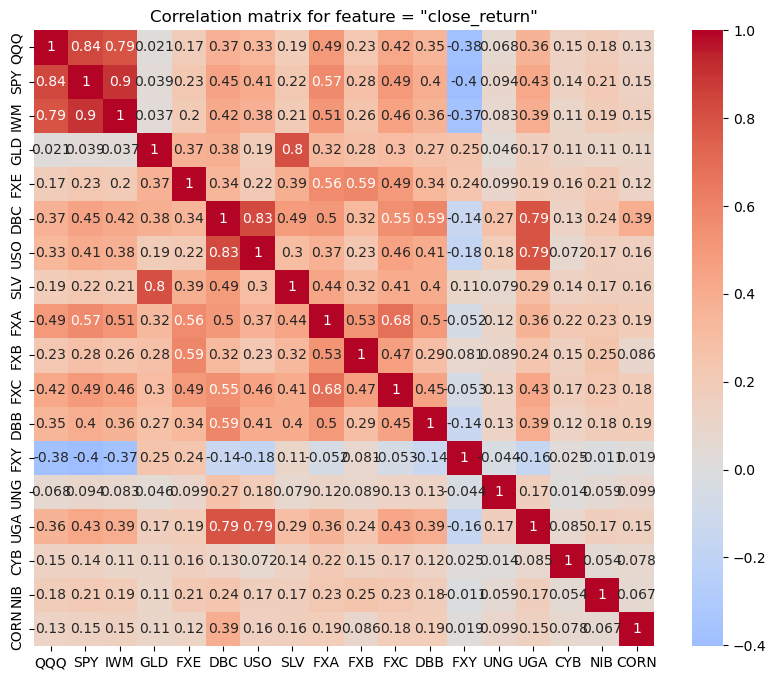

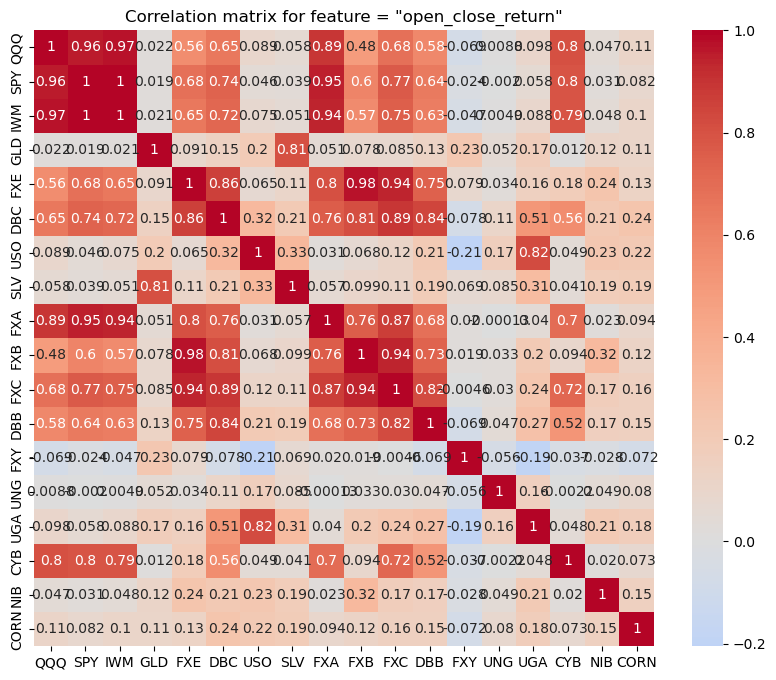

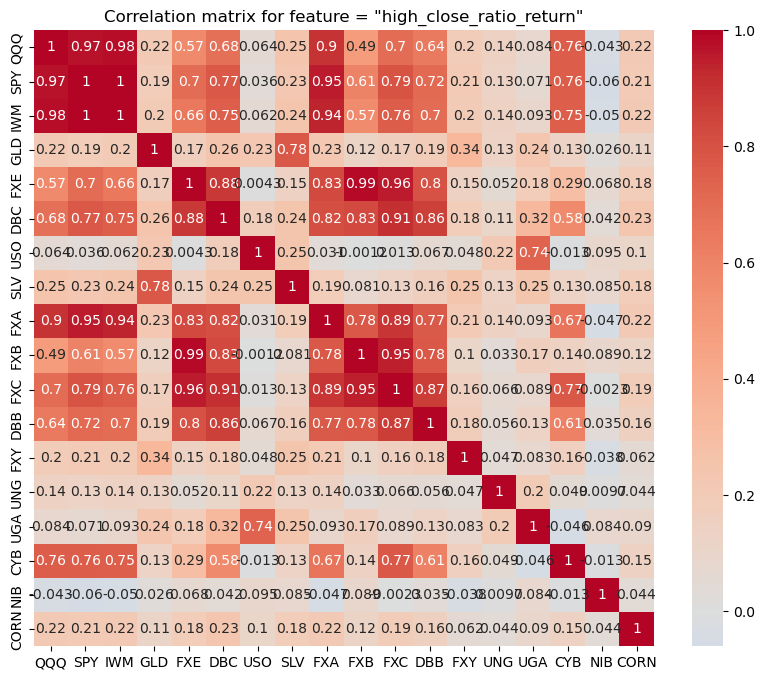

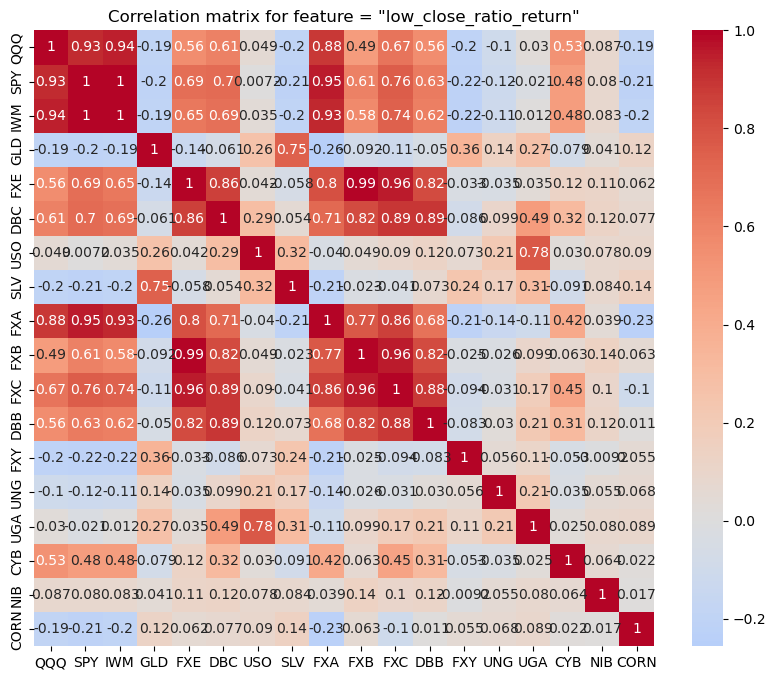

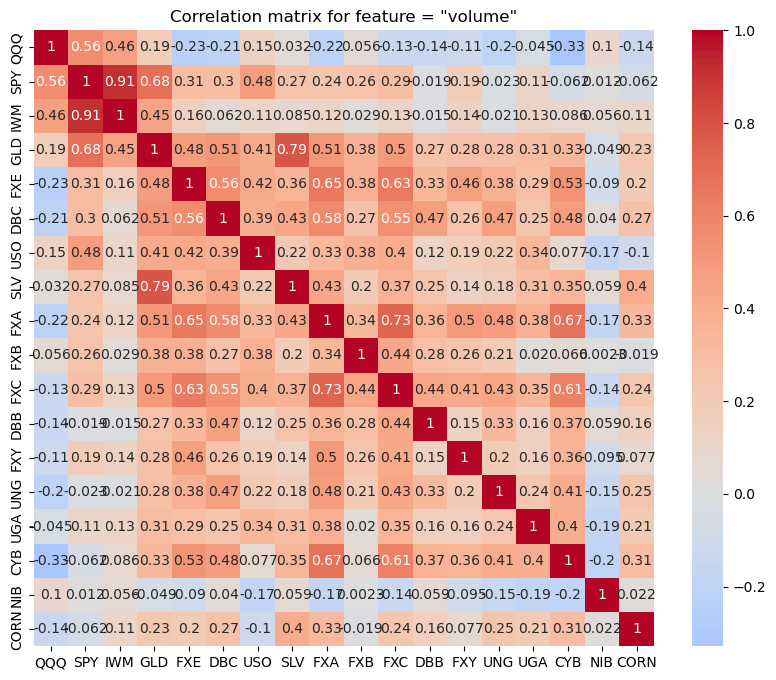

In [3]:
data_path ="/data3/hcxia/Adahist2/datasets/stock_data/megred_stock_data.csv"
macro_data_path = "/data3/hcxia/Adahist2/datasets/macro_processed/macro_data_resampled.csv"
output_path_folder = "/data3/hcxia/Adahist2/datasets/output_data/"
max_seq_len=120
output_data, output_macro_data, output_history_data,output_mask_data,output_starting_date, time, max_seq_len,ticker_list,output_orginal_open,output_orginal_close,output_adj_factor= data_preprocess(
    file_name=data_path, macro_file_name=macro_data_path, max_seq_len=max_seq_len
)
import numpy as np
print("X shape:", output_data.shape)
print("History shape:", output_history_data.shape)
print("Macro shape:", output_macro_data.shape)
# create the output folder if not exist
if not os.path.exists(output_path_folder):
    os.makedirs(output_path_folder)
# save the data to npy file
np.save(output_path_folder+"output_data.npy", output_data)
np.save(output_path_folder+"output_history_data.npy", output_history_data)
np.save(output_path_folder+"output_macro_data.npy", output_macro_data)
np.save(output_path_folder+"output_mask_data.npy", output_mask_data)
np.save(output_path_folder+"output_starting_date.npy", output_starting_date)
np.save(output_path_folder+"time.npy", time)
np.save(output_path_folder+"ticker_list.npy", ticker_list)
np.save(output_path_folder+"max_seq_len.npy", max_seq_len)
np.save(output_path_folder+"output_original_open.npy", output_orginal_open)
np.save(output_path_folder+"output_original_close.npy", output_orginal_close)
np.save(output_path_folder+"output_adj_factor.npy", output_adj_factor)

In [4]:
import numpy as np
preprossed_data_folder="/data3/hcxia/Adahist2/datasets/output_data"
# instead of processing the data each time, read the prossesed data from npy file

output_data = np.load(f"{preprossed_data_folder}/output_data.npy")
output_macro_data = np.load(f"{preprossed_data_folder}/output_macro_data.npy")
output_history_data = np.load(f"{preprossed_data_folder}/output_history_data.npy")
T = np.load(f"{preprossed_data_folder}/time.npy")
bbid_list = np.load(f"{preprossed_data_folder}/ticker_list.npy")
output_mask_data = np.load(f"{preprossed_data_folder}/output_mask_data.npy")
output_starting_date = np.load(f"{preprossed_data_folder}/output_starting_date.npy",allow_pickle=True)
max_seq_len = np.load(f"{preprossed_data_folder}/max_seq_len.npy")
output_orginal_open = np.load(f"{preprossed_data_folder}/output_original_open.npy")
output_orginal_close = np.load(f"{preprossed_data_folder}/output_original_close.npy")
import pandas as pd

# print the shape of the data
print("output_data shape:", output_data.shape)
print("output_macro_data shape:", output_macro_data.shape)
print("output_history_data shape:", output_history_data.shape)
print("output_mask_data shape:", output_mask_data.shape)

output_data_flat = output_data.reshape(-1, output_data.shape[-1])  # Flatten along the first two dimensions
output_mask_data_flat = output_mask_data.reshape(-1, output_mask_data.shape[-1])
output_macro_data_flat = output_macro_data.reshape(-1, output_macro_data.shape[-1])
output_history_data_flat = output_history_data.reshape(-1, output_history_data.shape[-1])
output_orginal_open_flat = output_orginal_open.flatten()
output_orginal_close_flat = output_orginal_close.flatten()

print(f"output_data: {pd.DataFrame(output_data_flat).describe()}")
print(f"output_mask_data: {pd.DataFrame(output_mask_data_flat).describe()}")
print(f"output_macro_data: {pd.DataFrame(output_macro_data_flat).describe()}")
print(f"output_history_data: {pd.DataFrame(output_history_data_flat).describe()}")
print(f"output_orginal_open: {pd.DataFrame(output_orginal_open_flat).describe()}")
print(f"output_orginal_close: {pd.DataFrame(output_orginal_close_flat).describe()}")

# print preview of the data
print("output_data: ", output_data_flat[:10])
print("output_mask_data: ", output_mask_data_flat[:10])
print("output_macro_data: ", output_macro_data_flat[:10])
print("output_history_data: ", output_history_data_flat[:10])
print("output_orginal_open: ", output_orginal_open_flat[:10])
print("output_orginal_close: ", output_orginal_close_flat[:10])

# only show the part where the mask is True
# print("output_data where mask is True: ", output_data_flat[output_mask_data_flat.flatten()])
# print("output_mask_data where mask is True: ", output_mask_data_flat[output_mask_data_flat.flatten()])
# print("output_macro_data where mask is True: ", output_macro_data_flat[output_mask_data_flat.flatten()])
# print("output_history_data where mask is True: ", output_history_data_flat[output_mask_data_flat.flatten()])

output_data shape: (5164, 120, 90)
output_macro_data shape: (5164, 120, 46)
output_history_data shape: (5164, 120, 90)
output_mask_data shape: (5164, 120, 90)
output_data:                   0              1              2              3   \
count  619680.000000  619680.000000  619680.000000  619680.000000   
mean       -0.003948      -0.536203      -0.479843      -0.614717   
std         1.075275       1.205990       1.274719       1.296647   
min        -5.556996     -13.633199      -3.955724     -17.718804   
25%        -0.582087      -1.185399      -1.243278      -1.214192   
50%         0.047491      -0.523115      -0.775216      -0.383811   
75%         0.626692       0.158247      -0.010289       0.275431   
max         5.624010      13.884750      21.032465       1.446740   

                  4              5              6              7   \
count  619680.000000  619680.000000  619680.000000  619680.000000   
mean        0.104493      -0.006525      -1.515194      -1.358244   